In [12]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
import os
from glob import glob
from osgeo import gdal
import json

gdal.UseExceptions()

In [13]:
# for the S1 VV and VH mosaics:
#   - clip to AOI
#   - save to new files
# for the arctic DEM tiles:
#   - select grid shapefile tiles that intersect AOI and save tile numbers
#   - select DEM tiles that correspond to those tile numbers
#   - mosaic DEM tiles for each of aspect, slope, hillshade, elevation
#   - clip to AOI for each of aspect, slope, hillshade, elevation
#   - save to new files
# for the S2 MSI tiles:
#   - read in grid CSV and select gridcells that intersect AOI and save cell numbers
#   - select S2 MSI tiles that correspond to those cell numbers
#   - mosaic S2 MSI tiles for each of B02, B03, B04, B05, B06, B07, B8A, B11, B12
#   - clip to AOI for each of B02, B03, B04, B05, B06, B07, B8A, B11, B12
#   - save to new files

# Paths to files

In [14]:
# S1 paths
outdir = "/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out"
s1_tiles = sorted(glob("/mnt/poseidon/remotesensing/arctic/data/rasters/s1_grd_tiled/*.tif"))

In [15]:
# **NEW** S2 MSI paths
pavc_grid_csv = "/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/panarctic_grid/panarctic_0p25_gridcells.csv"
s2_base_pth = "/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/composites"

In [16]:
# ArcticDEM paths
ak_grid_shp = "/mnt/poseidon/remotesensing/arctic/data/vectors/supplementary/tundra_alaska_grid_latlon_aoi/tundra_alaska_grid_aoi.shp"
dem_tiles = sorted(glob("/mnt/poseidon/remotesensing/arctic/data/rasters/arctic_dem_tiled/GRIDCELL_*.tif"))

# Quick Visualizations

In [17]:
gdf = gpd.GeoDataFrame({"id":[1]}, geometry=[box(-150, 67, -148, 69)], crs="EPSG:4326")
gdf.to_file("/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/toolik_aoi.shp", driver="ESRI Shapefile")

In [18]:
pavc_grid_df = pd.read_csv(pavc_grid_csv)
pavc_grid_df["geometry"] = pavc_grid_df.apply(lambda row: box(row.xmin, row.ymin, row.xmax, row.ymax), axis=1)
pavc_grid_gdf = gpd.GeoDataFrame(pavc_grid_df, geometry="geometry", crs="EPSG:4326")
pavc_grid_gdf.to_file("/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/panarctic_0p25_gridcells.shp", driver="ESRI Shapefile")

/tmp/ipykernel_398782/229263596.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pavc_grid_gdf.to_file("/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/panarctic_0p25_gridcells.shp", driver="ESRI Shapefile")
/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tile_id_geo' to 'tile_id_ge'
  ogr_write(


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
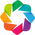

In [35]:
# EPSG:4326 pan-Arctic grid with GeoViews + Datashader (no basemap)
import pandas as pd
import geoviews as gv
import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from bokeh.io import export_png
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from bokeh.models import LinearAxis

opts = Options()
opts.add_argument("--headless=new")
opts.add_argument("--no-sandbox")
opts.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=Service(), options=opts)

hv.extension('bokeh'); gv.extension('bokeh')

# Load
df = pd.read_csv(pavc_grid_csv)
for c in ["xmin","ymin","xmax","ymax"]:
    df[c] = pd.to_numeric(df[c], errors="raise")

# Rectangles WITH CRS (very important)
rects = gv.Rectangles(
    df,
    kdims=["xmin","ymin","xmax","ymax"],
    vdims=["tile_id_rc"],
    crs=ccrs.PlateCarree()
).opts(line_color="black", line_width=0.3, fill_alpha=0)

# Area of interest bbox
bbox_shape = gv.Shape(box(-150, 67, -148, 69), crs=ccrs.PlateCarree()).opts(
    line_color="red", line_width=5, fill_alpha=0
)

# Build basemap
land = gv.Feature(cfeature.LAND).opts(fill_color="#f3efe6", line_color=None)
lakes = gv.Feature(cfeature.LAKES).opts(fill_color="#dbeeff", line_color=None)
glaciers = gv.Feature(cfeature.NaturalEarthFeature('physical','glaciated_areas','110m')
                    ).opts(fill_color="#eaf3ff", line_color=None)
coast = gv.Feature(cfeature.COASTLINE).opts(line_color="#666666", line_width=1)
borders = gv.Feature(cfeature.BORDERS).opts(line_color="#999999", line_width=0.8)
basemap = land * lakes * glaciers * coast * borders

# add frame to plot
def add_frame(plot, element):
    fig = plot.state
    fig.outline_line_color = "black"
    fig.outline_line_width = 2

# Now set limits IN DEGREES and force projection to EPSG:4326
plot = (basemap * rects * bbox_shape).opts(
    projection=ccrs.PlateCarree(),
    xlim=(-170, -145), ylim=(50, 75),
    width=3600, height=2400,
    bgcolor="#dbeeff",
    fontsize={"title": 32, "labels": 26, "ticks": 22}, 
    hooks=[add_frame],
)

# export
bk = hv.render(plot, backend='bokeh')
bk.width = 3600; bk.height = 2400
bk.toolbar_location = None
bk.toolbar.logo = None  
export_png(bk, filename="/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/panarctic_grid_toolik-aoi.png", webdriver=driver)
driver.quit()

# Basic Parameters

In [19]:
# params
bbox = box(-150, 67, -148, 69)
xres = 0.000179663056824 
yres = 0.000179663056824
epsg = 'EPSG:4326'

# Create temporaruy AOI GeoJSON
aoi_geojson = {
    "type": "FeatureCollection",
    "name": "aoi",
    "crs": {"type": "name", "properties": {"name": "EPSG:4326"}},
    "features": [{"type": "Feature", "properties": {}, "geometry": mapping(bbox)}],
}

# Write to GDAL's in-memory filesystem
aoi_path = "/vsimem/aoi.geojson"
_ = gdal.FileFromMemBuffer(aoi_path, json.dumps(aoi_geojson))

In [20]:
# select gridcells from shp that intersect AOI
ak_grid = gpd.read_file(ak_grid_shp)
ak_grid = ak_grid.to_crs(epsg)
ak_grid_aoi = ak_grid[ak_grid.intersects(bbox)]
ak_grid_aoi_ids = ak_grid_aoi["FID"].tolist()
print(ak_grid_aoi_ids[0:5])

[1933, 1934, 1935, 1936, 2021]


In [ ]:
# choose S2 gridcells that intersect AOI
pa_grid = pd.read_csv(pavc_grid_csv)
pa_grid["geometry"] = pa_grid.apply(lambda row: box(row.xmin, row.ymin, row.xmax, row.ymax), axis=1)
pa_grid = gpd.GeoDataFrame(pa_grid, geometry="geometry", crs="EPSG:4326")
pa_grid_aoi = pa_grid[pa_grid.intersects(bbox)]
pa_grid_aoi_ids = pa_grid_aoi["tile_id_rc"].tolist()
print(pa_grid_aoi_ids[0:5])

['Q025_R083_C0119', 'Q025_R083_C0120', 'Q025_R083_C0121', 'Q025_R083_C0122', 'Q025_R083_C0123']


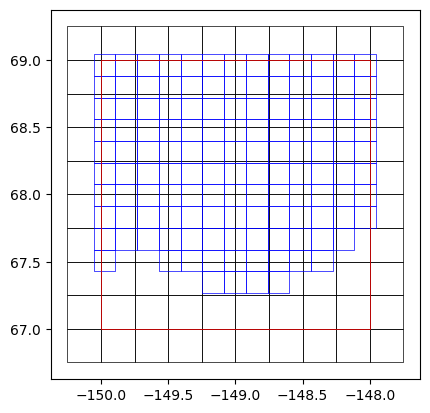

In [ ]:
# plot panarctic grid selection
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
pa_grid_aoi.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
ak_grid_aoi.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)
# add AOI box to plot
gpd.GeoSeries(bbox).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=0.5)
plt.show()

In [ ]:
# gdal progress callback
def gdal_progress_cb(complete, message, userdata):
    label = userdata or ""
    gdal.TermProgress_nocb(complete, label)
    return 1  # non-zero to continue, 0 would abort

# Prep OLD S1

In [ ]:
# select tifs that correspond to those gridcells
def select_ak_grid_tiles(tiles, ids, band):
    selected = []
    for tile in tiles:
        for id in ids:
            if f"GRIDCELL_{id}_{band}" in tile:
                selected.append(tile)
    return selected
s1_vv_aoi = select_ak_grid_tiles(s1_tiles, ak_grid_aoi_ids, "VV")
s1_vh_aoi = select_ak_grid_tiles(s1_tiles, ak_grid_aoi_ids, "VH")

In [ ]:
# create temporary mosaic of selected tiles
vv_vrt = "/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/s1_vv_mosaic.vrt"
vh_vrt = "/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/s1_vh_mosaic.vrt"

# for each of vv, vh, make a VRT mosaic
vrts = [vv_vrt, vh_vrt]
for vrt in vrts:
    ds = gdal.BuildVRT(
        vrt,
        s1_vv_aoi if vrt == vv_vrt else s1_vh_aoi,
        options=gdal.BuildVRTOptions(
            xRes=xres,
            yRes=yres,
            targetAlignedPixels=True,
            srcNodata=0,
            ),
        callback=gdal_progress_cb,
        callback_data="[BuildVRT] "
    )
    assert ds is not None, f"BuildVRT {vrt} returned None"
    ds = None
    assert gdal.VSIStatL(vrt) is not None, f"{vrt} not written"

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
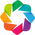

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/js_callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [ ]:
from holoviews.operation.datashader import rasterize, shade
from bokeh.plotting import show
import holoviews as hv
hv.extension('bokeh')

rast = rxr.open_rasterio(vh_vrt, masked=True).squeeze()
img = hv.Image(rast)
plot = shade(rasterize(img))
show(hv.render(plot))

In [ ]:
# gdal warp creation options
wo = {"NUM_THREADS": "ALL_CPUS", "INIT_DEST": "NO_DATA"}
co = [
    "TILED=YES",
    "COMPRESS=ZSTD",
    "ZSTD_LEVEL=15",
    "PREDICTOR=3",
    "BIGTIFF=YES",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512",
]

# gdal warp kwargs
kw = dict(
    cutlineDSName=aoi_path,
    cropToCutline=True,
    dstSRS=epsg,
    outputBounds=bbox.bounds,
    outputBoundsSRS="EPSG:4326",
    xRes=xres,
    yRes=yres,
    targetAlignedPixels=True,
    outputType=gdal.GDT_Float32,
    resampleAlg="bilinear",
    srcNodata=0,
    dstNodata=-9999,
    creationOptions=co,
    warpOptions=wo,
)

In [ ]:
# for each of VV, VH, warp and save to new file
for vrt, name in zip(vrts, ["VV", "VH"]):
    tif_aoi = os.path.join(outdir, f"S1_{name}_AOI.tif")
    gdal.Warp(tif_aoi, vrt, callback=gdal_progress_cb, callback_data=f"[Warp {name}] ", **kw)
    _ = gdal.Unlink(vrt)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
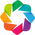

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/js_callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [ ]:
from holoviews.operation.datashader import rasterize, shade
from bokeh.plotting import show
import holoviews as hv
hv.extension('bokeh')

tif_aoi = os.path.join(outdir, f"S1_VH_AOI.tif")
rast = rxr.open_rasterio(tif_aoi, masked=True).squeeze()
img = hv.Image(rast)
plot = shade(rasterize(img))
show(hv.render(plot))

# Prep NEW S2


In [ ]:
# gdal warp creation options
wo = {"NUM_THREADS": "ALL_CPUS", "INIT_DEST": "NO_DATA"}
co = [
    "TILED=YES",
    "COMPRESS=ZSTD",
    "ZSTD_LEVEL=15",
    "PREDICTOR=2",
    "BIGTIFF=YES",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512",
]

# gdal warp kwargs
kw = dict(
    cutlineDSName=aoi_path,
    cropToCutline=True,
    dstSRS=epsg,
    outputBounds=bbox.bounds,
    outputBoundsSRS="EPSG:4326",
    xRes=xres,
    yRes=yres,
    targetAlignedPixels=True,
    outputType=gdal.GDT_Float32,
    resampleAlg="nearest",
    dstNodata=-9999,
    creationOptions=co,
    warpOptions=wo,
)

In [ ]:
# select tifs that correspond to those gridcells
def select_pavc_tiles(tiles, ids, band):
    selected = []
    for tile in tiles:
        for id in ids:
            if f"cell_{id}_{band}" in tile:
                selected.append(tile)
    return selected

In [ ]:
# loop through S2 bands
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
for band in bands:

    print(f"Processing S2 band {band}...")

    s2_tiles = sorted(glob(f"{s2_base_pth}/*/cell_*_{band}_median_clip.tif"))
    s2_aoi = select_pavc_tiles(s2_tiles, pa_grid_aoi_ids, band)

    # create temporary mosaic of selected tiles
    print(f"  - creating VRT mosaic for band {band}...")
    s2_vrt = f"/mnt/poseidon/remotesensing/arctic/data/rasters/esa_sentinel/s2_sr/tmp/out/s2_{band}_mosaic.vrt"
    ds = gdal.BuildVRT(
        s2_vrt, 
        s2_aoi,
        callback=gdal_progress_cb, 
        callback_data=f"[BuildVRT {band}] "
    )
    assert ds is not None, f"BuildVRT {band} returned None"
    ds = None
    assert gdal.VSIStatL(s2_vrt) is not None, f"{band} VRT not written"

    # clip and save to new files
    print(f"  - warping and saving clipped tif for band {band}...")
    s2_tif_aoi = os.path.join(outdir, f"S2_{band}_AOI.tif")
    gdal.Warp(s2_tif_aoi, s2_vrt, callback=gdal_progress_cb, callback_data=f"[Warp {band}] ", **kw)
    
    # clean up
    _ = gdal.Unlink(s2_vrt)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
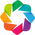

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/js_callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [ ]:
from holoviews.operation.datashader import rasterize, shade
from bokeh.plotting import show
import holoviews as hv
hv.extension('bokeh')

tif_path = os.path.join(outdir, f"S2_B08_AOI.tif")
rast = rxr.open_rasterio(tif_path, masked=True).squeeze()
img = hv.Image(rast)
plot = shade(rasterize(img))
show(hv.render(plot))

# Prep ArcticDEM

In [ ]:
# select DEM gridcells that intersect AOI
ad_aspect = select_ak_grid_tiles(dem_tiles, ak_grid_aoi_ids, "dem_aspect")
ad_hillshade = select_ak_grid_tiles(dem_tiles, ak_grid_aoi_ids, "dem_hillshade")
ad_slope = select_ak_grid_tiles(dem_tiles, ak_grid_aoi_ids, "dem_slope")
ad_elevation = select_ak_grid_tiles(dem_tiles, ak_grid_aoi_ids, "dem")

In [ ]:
ad_aspect[0:5]

In [ ]:
# gdal warp creation options
wo = {"NUM_THREADS": "ALL_CPUS", "INIT_DEST": "NO_DATA"}
co = [
    "TILED=YES",
    "COMPRESS=ZSTD",
    "ZSTD_LEVEL=15",
    "PREDICTOR=3",
    "BIGTIFF=YES",
    "BLOCKXSIZE=512",
    "BLOCKYSIZE=512",
]

# gdal warp kwargs
kw = dict(
    cutlineDSName=aoi_path,
    cropToCutline=True,
    dstSRS=epsg,
    outputBounds=bbox.bounds,
    outputBoundsSRS="EPSG:4326",
    xRes=xres,
    yRes=yres,
    targetAlignedPixels=True,
    outputType=gdal.GDT_Float32,
    resampleAlg="bilinear",
    dstNodata=-9999,
    creationOptions=co,
    warpOptions=wo,
)

In [ ]:
# create temporary mosaic of selected tiles
aspect_vrt = "/vsimem/dem_aspect_mosaic.vrt"
hillshade_vrt = "/vsimem/dem_hillshade_mosaic.vrt"
slope_vrt = "/vsimem/dem_slope_mosaic.vrt"
elevation_vrt = "/vsimem/dem_elevation_mosaic.vrt"

# for each of aspect, slope, hillshade, elevation, make a VRT mosaic
vrts = [aspect_vrt, hillshade_vrt, slope_vrt, elevation_vrt]
for vrt in vrts:
    ds = gdal.BuildVRT(
        vrt, 
        s1_vv_aoi,
        callback=gdal_progress_cb, 
        callback_data="[BuildVRT] ")
    assert ds is not None, f"BuildVRT {vrt} returned None"
    ds = None
    assert gdal.VSIStatL(vrt) is not None, f"{vrt} not written"

In [ ]:
# for each of aspect, slope, hillshade, elevation, warp and save to new file
for vrt, name in zip(vrts, ["aspect", "hillshade", "slope", "elevation"]):
    tif_aoi = os.path.join(outdir, f"DEM_{name}_AOI.tif")
    gdal.Warp(tif_aoi, vrt, callback=gdal_progress_cb, callback_data=f"[Warp {name}] ", **kw)
    _ = gdal.Unlink(vrt)

# 01_northslope_pft_mapping.py

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import rioxarray as rxr
import xarray as xr
import pickle
import logging
from osgeo import gdal
from datetime import datetime
import sys

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H%M%S")

#########################################################################
# Parameters
#########################################################################

# general params
BASE = '/mnt/poseidon/remotesensing/arctic/data'
OUT_DIR = f'{BASE}/rasters/model_results_tiled_toolik_09-22-2025'
DATA_DIR = f'{BASE}/rasters'
REF_RAST = f'{DATA_DIR}/esa_sentinel/s2_sr/tmp/out/S2_B02_AOI.tif'
MODEL = f'{BASE}/training/Test_06/results/03'

# gdalwarp params
DST_NODATA = 255
XRES = 0.000179663056824
YRES = 0.000179663056824
EPSG = 'EPSG:4326'

# specify pkl file names and map to associated PFT
pft_file_map = {
    "bryophyte": {
        "model": "bryophyte_30m_parent_sources5_IQR3.pkl",
        "outfile_suffix": "30M-5P-IQR3",
    },
    "lichen": {
        "model": "lichen_55m_parent_sources3_IQR2.5.pkl",
        "outfile_suffix": "55M-3P-IQR2.5",
    },
    "deciduous shrub": {
        "model": "deciduous shrub_30m_child_sources3_IQR2.pkl",
        "outfile_suffix": "30M-3C-IQR2",
    },
    "evergreen shrub": {
        "model": "evergreen shrub_30m_parent_sources4_IQR2.5.pkl",
        "outfile_suffix": "30M-4P-IQR2.5",
    },
    "forb": {
        "model": "forb_55m_child_sources5_IQR1.5.pkl",
        "outfile_suffix": "55M-5C-IQR1.5",
    },
    "graminoid": {
        "model": "graminoid_30m_parent_sources3_IQR2.pkl",
        "outfile_suffix": "30M-3P-IQR2",
    },
    "non-vascular": {
        "model": "non-vascular_30m_parent_sources2_IQR1.5.pkl",
        "outfile_suffix": "30M-2P-IQR1.5",
    },
    "litter": {
        "model": "litter_30m_parent_sources2_IQR3.pkl",
        "outfile_suffix": "30M-2P-IQR3",
    },
}

# Sensor-specific Params
S2_DIR = f'{DATA_DIR}/esa_sentinel/s2_sr/tmp/out/S2_*.tif'
S1_DIR = f'{DATA_DIR}/esa_sentinel/s2_sr/tmp/out/S1_*.tif'
DEM_DIR = f'{DATA_DIR}/esa_sentinel/s2_sr/tmp/out/DEM_*.tif'

# logging configuration
os.makedirs(OUT_DIR, exist_ok=True)
logging.basicConfig(
    level=logging.INFO,
    filename=f'{OUT_DIR}/std_{dt_string}.log',
    filemode='w',
    format='%(asctime)s >>> %(message)s',
    datefmt='%d-%b-%y %H:%M:%S'
)

#########################################################################
# Definitions
#########################################################################

# function to stack sensor bands for one gridcell
# will need to loop through each sensor and gridcell
def stack_bands(band_paths, ref_rast, scale_factor=None):
    
    """
    Creates an xarray with each band recorded as a variable.
    bands_paths    : [list] list of file paths to each band
    ref_rast       : [xr.Dataset] raster used as the model resolution/crs
    scale_factor   : [float or int] number multiplied to rescale data
    Returns an xr.Dataset with x,y,band dimensions for one gridcell with 
    each band as a data variable that matches the resolution/scale of the
    reference raster.
    """

    raster_bands = []
    for band_path in band_paths:

        # get file name from file path
        print(band_path)
        filename = os.path.basename(band_path)
        b_name = filename.split('_')[-2]  # assumes format <source>_<band>_AOI.tif
        
        # open raster in xarray
        raster = rxr.open_rasterio(band_path)
        raster.name = b_name

        # set nodata values to nan and rescale
        raster = raster.rio.reproject_match(ref_rast)
        raster = raster.where(raster != 0, -9999)
        if scale_factor is not None:
            raster = raster * scale_factor

        raster_bands.append(raster)

    merged = xr.merge(raster_bands)
    merged = merged.dropna(dim='band', how='any')
    return merged
    
# function that creates new veg idx data variables for an xr
def calc_veg_idx_s2(xrd):
    
    """
    Creates new data attributes for an s2_sr xr.Dataset with bands
    B2, B3, B4, B5, B6, B8, B8A, B11, and B12. Second step after 
    stack_bands. S2_sr data must be scaled from 0 to 1; can set
    scale factor in stack_bands function if necessary.
    xrd : [xr.Dataset] s2_sr xarray dataset
    Returns: xarray dataset with new vegetation indices
    """
    
    xrd = xrd.assign(ndwi1 = lambda x: (x.nir - x.swir1)/(x.nir + x.swir2))
    xrd = xrd.assign(ndwi2 = lambda x: (x.nir - x.swir2)/(x.nir + x.swir2))
    xrd = xrd.assign(msavi = lambda x: (2*x.nir + 1 - ((2*x.nir + 1)**2 - 8*(x.nir - x.red))**0.5) * 0.5)
    xrd = xrd.assign(vari = lambda x: (x.green - x.red)/(x.green + x.red - x.blue))
    xrd = xrd.assign(rvi = lambda x: x.nir/x.red)
    xrd = xrd.assign(osavi = lambda x: 1.16 * (x.nir - x.red)/(x.nir + x.red + 0.16))
    xrd = xrd.assign(tgi = lambda x: (120 * (x.red - x.blue) - 190 * (x.red - x.green))*0.5)
    xrd = xrd.assign(gli = lambda x: (2 * x.green - x.red - x.blue)/(2 * x.green + x.red + x.blue))
    xrd = xrd.assign(ngrdi = lambda x: (x.green - x.red)/(x.green + x.red))
    xrd = xrd.assign(ci_g = lambda x: x.nir/x.green - 1)
    xrd = xrd.assign(gNDVI = lambda x: (x.nir - x.green)/(x.nir + x.green))
    xrd = xrd.assign(cvi = lambda x: (x.nir * x.red)/(x.green ** 2))
    xrd = xrd.assign(mtvi2 = lambda x: 1.5*(1.2*(x.nir - x.green) - 2.5*(x.red - x.green))/(((2*x.nir + 1)**2 - (6*x.nir - 5*(x.red**0.5))-0.5)**0.5))
    xrd = xrd.assign(brightness = lambda x: 0.3037 * x.blue +0.2793 * x.green +0.4743 * x.red +0.5585 * x.nir +0.5082 * x.swir1 + 0.1863 * x.swir2)
    xrd = xrd.assign(greenness = lambda x: 0.7243 * x.nir +0.0840 * x.swir1 - 0.2848 * x.blue - 0.2435 * x.green - 0.5436 * x.red - 0.1800 * x.swir2)
    xrd = xrd.assign(wetness = lambda x: 0.1509 * x.blue+0.1973* x.green+0.3279*x.red+0.3406*x.nir-0.7112*x.swir1 - 0.4572*x.swir2)
    xrd = xrd.assign(tcari = lambda x: 3 * ((x.redEdge1 - x.red)-0.2 * (x.redEdge1 - x.green)*(x.redEdge1/x.red)))
    xrd = xrd.assign(tci = lambda x: 1.2 * (x.redEdge1 - x.green)- 1.5 * (x.red - x.green)*((x.redEdge1/x.red)**0.5))
    xrd = xrd.assign(nari = lambda x: (1/x.green - 1/x.redEdge1)/(1/x.green + 1/x.redEdge1))

    return xrd
    
#########################################################################
# Begin modeling
#########################################################################

# use an existing raster to ensure all rasters are aligned
reference_raster = rxr.open_rasterio(REF_RAST)
reference_raster = reference_raster.where(reference_raster != 0, -9999)
reference_raster = reference_raster * .0001


#########################################################################
# Sentinel 2 (nodata = -9999)
#########################################################################

# create 20-m xarray raster
s2_band_rasters = sorted(glob.glob(S2_DIR))
s2_stacked_raster = stack_bands( 
    s2_band_rasters,
    reference_raster,
    scale_factor = .0001,
)

# rename bands to something legible
s2_stacked_raster = s2_stacked_raster.rename({
    'B02':'blue', 
    'B03':'green',
    'B04':'red', 
    'B05':'redEdge1', 
    'B06':'redEdge2', 
    'B07':'redEdge3', 
    'B8A':'redEdge4', 
    'B08':'nir',
    'B11':'swir1',
    'B12':'swir2'})

# calculate vegetation indices
s2_stacked_raster_veg = calc_veg_idx_s2(s2_stacked_raster)


#########################################################################
# Sentinel 1 (nodata = -9999)
#########################################################################

# create 20-m xarray raster
s1_band_rasters = sorted(glob.glob(S1_DIR))
rescale_bands = ['VV', 'VH']
s1_stacked_raster = stack_bands(
    s1_band_rasters,
    reference_raster,
)
s1_stacked_raster = s1_stacked_raster.where(s1_stacked_raster[rescale_bands] != 0, -9999)


#########################################################################
# Arctic DEM (nodata = -9999)
#########################################################################

# create 20-m xarray raster
dem_band_rasters = sorted(glob.glob(DEM_DIR))
dem_stacked_raster = stack_bands(
    dem_band_rasters, 
    reference_raster,
)


#########################################################################
# Combine into one xarray
#########################################################################

# make sure pandas df features are in the right order
stacked_raster = xr.merge([s2_stacked_raster_veg, 
                            s1_stacked_raster, 
                            dem_stacked_raster])

# get coordinate information from raster as df
df = stacked_raster.to_dataframe()
coords = df.reset_index()
coords = coords[['x', 'y']]

# get raster data as df
df = df.droplevel([1, 2]).reset_index(drop=True)
df = df.iloc[:,1:]
df = df.replace(-9999, np.nan)

# find any bands that were divided by 0 and produced an inf value
bad_idx_list = df[np.isinf(df.values)].index.tolist()
df.drop(index=bad_idx_list, inplace=True)
coords.drop(index=bad_idx_list, inplace=True)

# remove straggling nans
nan_idx_list = df[np.isnan(df.values)].index.tolist()
df.drop(index=nan_idx_list, inplace=True)
coords.drop(index=nan_idx_list, inplace=True)

In [ ]:
#########################################################################
# Apply model
#########################################################################

for pft, pft_info in pft_file_map.items():

    # extract info from pft_info
    model = pft_info['model']
    outfile_suffix = pft_info['outfile_suffix']

    # define output file name
    pft_slug = pft.replace(" ", "_")
    outfile = f"{OUT_DIR}/{pft_slug}_{outfile_suffix}.tif"
    
    try:

        # get pickle path
        model_file_path = os.path.join(MODEL, "tunedModel_" + model)
        if not os.path.isfile(model_file_path):
            print(f"Model file not found: {model_file_path}. Exiting.")
            sys.exit(1)

        # load the pickled model
        with open(model_file_path, "rb") as f:
            model = pickle.load(f)

        # reorder df and predict
        col_order = model.feature_names_in_.tolist()
        df2 = df2[col_order]
        fcover = model.predict(df2)  # fcover is 1 x n
        fcover = (fcover * 100).astype(int)
        
    except Exception as e:
        print(f"Modeling failed for '{pft}': {e}")
        continue

    
    #########################################################################
    # Export modeled tif
    #########################################################################

    # set up df for xarray
    results = coords.copy()
    results['fcover'] = fcover
    results['band'] = 1
    
    # export xarray as tif
    try:
        results_xr = xr.Dataset.from_dataframe(results.set_index(['band', 'y', 'x']))
        xr_band = results_xr.isel(band=0).rio.write_crs('EPSG:4326')
        xr_band.rio.to_raster(outfile)
        print(f"Exported {outfile}")
        
    except Exception as e:
        print(f"Exception found while exporting '{pft}': {e}")
        continue
        
    # set crs
    opts = gdal.WarpOptions(
        format='GTiff', 
        dstSRS=EPSG, 
        dstNodata=DST_NODATA,
        outputBounds=bbox.bounds,
        outputType=gdal.GDT_Int16,
        resampleAlg='bilinear',
        xRes=XRES,
        yRes=YRES,
        targetAlignedPixels=True,
    )
    gdal.Warp(outfile, outfile, options=opts)

In [ ]:
path = "/mnt/poseidon/remotesensing/arctic/data/training/Test_06/results/03/tunedModel_bryophyte_30m_parent_sources5_IQR3.pkl"  # <- change me
model_pkl = pickle.load(open(path, "rb"))
feature_order = model_pkl.feature_names_in_.tolist()
print(feature_order)